# Model Garbage Classification
Capstone Project SIB Kampus Merdeka X Dicoding.
Team ID: **CSD-114**

Datasets: [Kaggle Garbage Classification (12 classes)](https://www.kaggle.com/mostafaabla/garbage-classification)

# Install & Import Library

## Install

### TensorFlow.js

In [1]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 81 kB 4.5 MB/s 
     |████████████████████████████████| 180 kB 16.2 MB/s 
     |████████████████████████████████| 40 kB 5.3 MB/s 
     |████████████████████████████████| 145 kB 61.2 MB/s 
     |████████████████████████████████| 217 kB 57.7 MB/s 
     |████████████████████████████████| 51 kB 7.9 MB/s 
     |████████████████████████████████| 85 kB 4.5 MB/s 
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3


### Kaggle

In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import

In [3]:
import os
import shutil
import zipfile
import pathlib

import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

print(f'Tensorflow version: {tf.__version__}')

Tensorflow version: 2.8.2


# Data Preparation

## Data Collecting

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!mkdir ~/.kaggle

In [6]:
!cp /content/drive/MyDrive/Skripsi/kaggle.json ~/.kaggle/

In [7]:
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download virgiawan/12-classes-garbage-classification

 94% 76.0M/80.6M [00:00<00:00, 120MB/s]
100% 80.6M/80.6M [00:00<00:00, 122MB/s]


In [9]:
local_zip = '/content/12-classes-garbage-classification.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

PATH = '/content/garbage_classification'
PATH

'/content/garbage_classification'

In [10]:
data_dir = pathlib.Path(PATH)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'Total image from this datasets : {image_count}')

print(f'\nDistribution Image')
for i, label in enumerate(os.listdir(data_dir)):
  label_dir = os.path.join(data_dir, label)
  len_label_dir = len(os.listdir(label_dir))
  print(f'{i+1}. {label} : {len_label_dir}')

Total image from this datasets : 7692

Distribution Image
1. battery : 642
2. biological : 648
3. shoes : 647
4. cardboard : 643
5. plastic : 645
6. white-glass : 645
7. trash : 647
8. brown-glass : 607
9. paper : 645
10. clothes : 645
11. metal : 649
12. green-glass : 629


## Data Preprocessing & Transformation

### Set up Paramters

In [11]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

np.random.seed(123)
seed = np.random.randint(0,100)
print(f"Current seed : {seed}")

Current seed : 66


### Load data using a Keras utility

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 7692 files belonging to 12 classes.
Using 6154 files for training.
Found 7692 files belonging to 12 classes.
Using 1538 files for validation.


In [13]:
class_names = train_ds.class_names
class_names_val = val_ds.class_names

print(f'List label Train data: \n{class_names}\n')
print(f'List label Validation data: \n{class_names_val}')

List label Train data: 
['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

List label Validation data: 
['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


### Check Image batch

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


### Plot Data

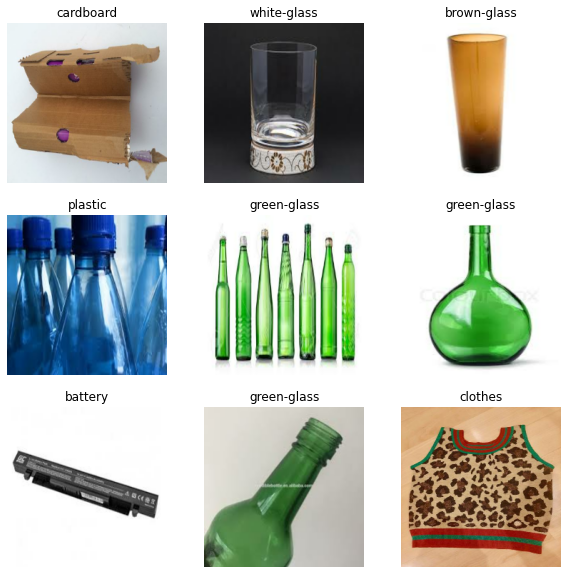

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Split Validation data to Test data

In [16]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 40
Number of test batches: 9


### Configure data performance for Training

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Create Layer & Model

## Layer

### Data Augmentation Layer

In [18]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2)],
  name="data_augmentation")

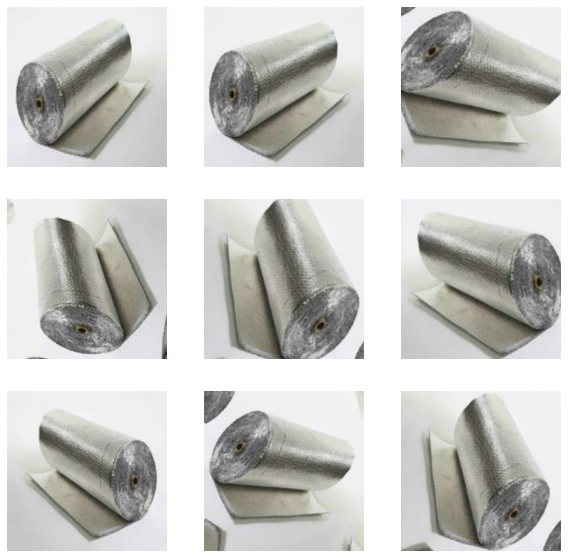

In [19]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel Layer

In [20]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

### Global Average Layer

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

### Base Model Layer

In [22]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [23]:
base_model.trainable = False

### Input Layer

In [24]:
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))

## Model

In [25]:
def model_builder():

  # Number Classes from data
  num_classes = len(class_names)

  # Create Model Sequential keras
  model = tf.keras.Sequential()

  # Add Custom Layer
  model.add(inputs)
  model.add(data_augmentation)
  model.add(normalization_layer)
  model.add(base_model)
  model.add(global_average_layer)

  # Add fully connected layer with dropout
  model.add(tf.keras.layers.Dense(units=512, activation="relu"))
  model.add(tf.keras.layers.Dropout(0.2))

  # Prediction Layer
  model.add(tf.keras.layers.Dense(num_classes, activation='softmax', name="final_output"))

  base_learning_rate = 1e-3
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

  return model

#### Define Callbacks

In [26]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("checkpoint_model.h5", 
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", 
                                                  patience=10, 
                                                  mode ="max", 
                                                  verbose=2, 
                                                  restore_best_weights=True)

In [27]:
model = model_builder()
print(f"Model : {model}")

Model : <keras.engine.sequential.Sequential object at 0x7fbd2c257fd0>


# Train & Test Model

## Train

In [28]:
history = model.fit(train_ds,
                    epochs=100,
                    validation_data=val_ds,
                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/100
192/193 [============================>.] - ETA: 0s - loss: 0.7977 - accuracy: 0.7460
Epoch 1: val_accuracy improved from -inf to 0.85280, saving model to checkpoint_model.h5
193/193 [==============================] - 27s 67ms/step - loss: 0.7993 - accuracy: 0.7454 - val_loss: 0.4503 - val_accuracy: 0.8528
Epoch 2/100
193/193 [==============================] - ETA: 0s - loss: 0.4747 - accuracy: 0.8438
Epoch 2: val_accuracy improved from 0.85280 to 0.88240, saving model to checkpoint_model.h5
193/193 [==============================] - 10s 54ms/step - loss: 0.4747 - accuracy: 0.8438 - val_loss: 0.3393 - val_accuracy: 0.8824
Epoch 3/100
193/193 [==============================] - ETA: 0s - loss: 0.3950 - accuracy: 0.8692
Epoch 3: val_accuracy improved from 0.88240 to 0.90000, saving model to checkpoint_model.h5
193/193 [==============================] - 10s 54ms/step - loss: 0.3950 - accuracy: 0.8692 - val_loss: 0.2946 - val_accuracy: 0.9000
Epoch 4/100
192/193 [================

### Plot Result

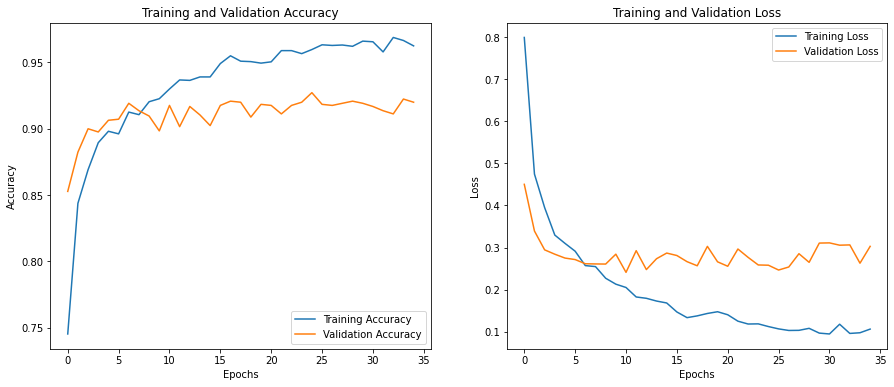

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Test

In [30]:
load_model = tf.keras.models.load_model('checkpoint_model.h5')

In [31]:
load_model.evaluate(x=test_dataset, return_dict=True)

9/9 [==============================] - 2s 53ms/step - loss: 0.2787 - accuracy: 0.9236


{'loss': 0.2787492871284485, 'accuracy': 0.9236111044883728}

Saving image.webp to image.webp
image.webp
clothes
[[4.3529353e-09 7.1487527e-10 3.1354733e-10 3.6088363e-06 9.8032838e-01
  3.1013270e-10 3.3318841e-08 1.9665413e-02 2.5151558e-06 2.1218740e-11
  2.8469313e-10 6.0626748e-09]]
0.9803284


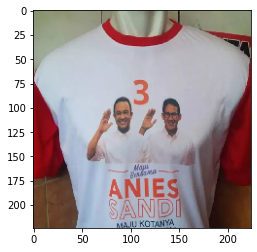

In [32]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size= IMG_SIZE + (3,))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = load_model.predict(images, batch_size=10)
  outclass = np.argmax(classes)
  
  print(fn)
  plt.imshow(img)
  for i, label in enumerate(class_names):
    if outclass == i:
      predic = classes[0][i]
      print(label)
      print(classes)
      print(predic)


# Convet Model Into JSON

In [41]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [42]:
path_model = './saved'
output_path = '/content/output_path'
load_model.save(path_model)

In [43]:
print(path_model)

./saved


In [44]:
path_model=pathlib.Path(path_model)
print(path_model)

saved


In [45]:
!tensorflowjs_converter --input_format=tf_saved_model \
                         --output_node_names='MobilenetV3/Predictions/Reshape_1' \
                         --saved_model_tags=serve \
                         './saved' \
                         output_path

2022-10-02 07:30:52.764141: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Writing weight file output_path/model.json...


# Download Model JSON

## Archive

In [46]:
shutil.make_archive('/content/json', 'zip', output_path)

'/content/json.zip'

## Download

In [47]:
files.download('/content/json.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>